In [44]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, MaxPooling2D, Deconvolution2D, UpSampling2D, BatchNormalization
import os
import random
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from keras import regularizers

In [2]:
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

x_train.shape

4423680/4422102 [==============================] - 1s 0us/step


(60000, 28, 28, 1)

In [45]:
input_img = Input(shape=(28,28,1))
x = Conv2D(16, (3, 3), activation="relu", padding="same")(input_img)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2))(x)

# FC
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
encoded = Dense(1024, activation='relu', activity_regularizer=regularizers.l1(10e-10))(x)

x = Dense(1024, activation='relu')(encoded)
x = Dense(1024, activation='relu')(x)
x = Dense(3136, activation='sigmoid')(x)
x = Reshape((7, 7, 64))(x)

#CONV

x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
decoded = Conv2D(1, (1, 1), padding="same")(x)

model = Model(inputs=input_img, outputs=decoded)

In [46]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 32)        9248

In [47]:
model.compile(optimizer='adam', loss="mse")

In [ ]:
model.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 15s 251us/step - loss: 0.0105 - val_loss: 0.0109
Epoch 2/5
60000/60000 [==============================] - 15s 251us/step - loss: 0.0100 - val_loss: 0.0100
Epoch 3/5
20736/60000 [=========>....................] - ETA: 9s - loss: 0.0097

In [10]:
input_img = model.get_layer("input_1").input
encoded = model.get_layer("dense_2").output

In [11]:
encoder = Model(inputs=input_img, outputs=encoded)

In [12]:
sample_x, sample_y = x_train[:20], y_train[:20]
sample_x, sample_y = np.squeeze(sample_x), np.squeeze(sample_y)

In [14]:
%matplotlib inline
print(sample_y)
def show_sample(ind):
    plt.figure()
    plt.imshow(sample_x[ind])
    plt.figure()
    pred = model.predict(np.expand_dims(np.expand_dims(sample_x[ind], axis=2), axis=0))
    plt.imshow(np.squeeze(pred))
    
interact(show_sample,ind=widgets.IntSlider(min=0, max=19, step=1, value=5))

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4]


interactive(children=(IntSlider(value=5, description='ind', max=19), Output()), _dom_classes=('widget-interact…

<function __main__.show_sample(ind)>

In [17]:
from sklearn import manifold, datasets

In [18]:
import matplotlib.colors as mcolors
color_set = mcolors.TABLEAU_COLORS
cnames = list(color_set.keys())

In [22]:
encoded_samp = encoder.predict(x_train[:2000])

In [29]:
tsne = manifold.TSNE(n_components=2, init='random', perplexity=400, n_jobs=-1, verbose=1)

In [30]:
embedded_samp = tsne.fit_transform(encoded_samp)

[t-SNE] Computing 1201 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.550s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 3.201298
[t-SNE] KL divergence after 100 iterations with early exaggeration: 48.197029
[t-SNE] KL divergence after 1000 iterations: 0.257111


In [34]:
clist = [color_set[cnames[label]] for label in y_train[:2000]]

In [35]:
from mpl_toolkits import mplot3d
%matplotlib inline

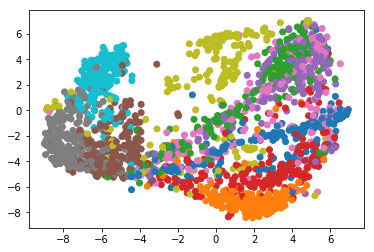

In [36]:
# 2D
embedded_x, embedded_y = np.split(embedded_samp, 2, axis=1)
plt.scatter(embedded_x, embedded_y, c=clist)

# # 3D
# fig = plt.figure()
# ax = plt.axes(projection='3d')

# embedded_x, embedded_y, embedded_z = np.split(embedded_samp, 3, axis=1)
# ax.scatter3D(embedded_x, embedded_y, embedded_z, c=clist)

In [ ]:
x_flat = np.array([vec.flatten() for vec in x_train[:10000]])
x_flat.shape

In [ ]:
tsne = manifold.TSNE(n_components=3, init='random', perplexity=400, n_jobs=-1, verbose=1)

In [ ]:
embedded_flat_samp = tsne.fit_transform(x_flat)

In [ ]:
# 2D
# embedded_x, embedded_y = np.split(embedded_samp, 2, axis=1)
# plt.scatter(embedded_x, embedded_y, c=clist)

# 3D
fig = plt.figure()
ax = plt.axes(projection='3d')

embedded_x, embedded_y, embedded_z = np.split(embedded_flat_samp, 3, axis=1)
ax.scatter3D(embedded_x, embedded_y, embedded_z, c=clist)

In [ ]:
model_json = loaded_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
loaded_model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [37]:
def get_vec(ind):
    pred = encoder.predict(np.expand_dims(np.expand_dims(sample_x[ind], axis=2), axis=0))
    vec = np.reshape(pred, 512)
    vec /= np.linalg.norm(vec)
    return vec

In [38]:
def similarity(ind0, ind1):
    print(f"Class 0: {sample_y[ind0]}")
    print(f"Class 1: {sample_y[ind1]}")
    print(get_vec(ind0)@get_vec(ind1))

In [39]:
interact(similarity,ind0=widgets.IntSlider(min=0, max=19, step=1, value=5),ind1=widgets.IntSlider(min=0, max=19, step=1, value=5))

interactive(children=(IntSlider(value=5, description='ind0', max=19), IntSlider(value=5, description='ind1', m…

<function __main__.similarity(ind0, ind1)>

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [ ]:
vecs = np.array([get_vec(i) for i in range(20)])
(vecs @ vecs.T).shape
plt.matshow(vecs @ vecs.T)
_ = plt.xticks(np.arange(20), sample_y[:20])
_ = plt.yticks(np.arange(20), sample_y[:20])

In [2]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, batch_size=32, dim=(16, 200), n_channels=1, shuffle=True):
        'Initialization'
        self.files = []
        self.indexes = None
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.files)/self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        files_temp = [self.files[k] for k in indexes]

        # Generate data
        X = self._load_files(files_temp)

        return X, X
    
    def load_directory(self, directory, extension="npy"):
        orig_len = len(self.files)
        self.files.extend([os.path.join(directory, x) for x in os.listdir(directory) if x.endswith(extension)])
        self.files = list(set(self.files))
        print("%d files added" % (len(self.files) - orig_len))
        print("%d files in total" % len(self.files))
        if self.shuffle:
            random.shuffle(self.files)
        self.indexes = np.arange(len(self.files))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            random.shuffle(self.files)

    def _load_files(self, files):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, file in enumerate(files):
            # Store sample
            X[i,] = np.expand_dims(np.load(file), axis=2)

        return X

In [3]:
filtered_dir = "GBT_57532_09539_HIP56445_fine/filtered"
data_gen = DataGenerator()

In [5]:
for i in range(22):
    data_gen.load_directory(f"{filtered_dir}/{i}")

0 files added
7115 files in total
0 files added
7115 files in total
0 files added
7115 files in total
14 files added
7129 files in total
16 files added
7145 files in total
9959 files added
17104 files in total
506 files added
17610 files in total
49728 files added
67338 files in total
26552 files added
93890 files in total
51170 files added
145060 files in total
61 files added
145121 files in total
3014 files added
148135 files in total
43 files added
148178 files in total
20794 files added
168972 files in total
3195 files added
172167 files in total
68528 files added
240695 files in total
46019 files added
286714 files in total
4992 files added
291706 files in total
47339 files added
339045 files in total
612 files added
339657 files in total
4935 files added
344592 files in total
2588 files added
347180 files in total


In [6]:
input_img = Input(shape=(16, 200, 1))
x = Conv2D(16, (3, 3), activation="relu", padding="same")(input_img)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(encoded)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Conv2D(16, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), padding="same")(x)

model = Model(inputs=input_img, outputs=decoded)


In [7]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 200, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 200, 16)       160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 200, 32)       4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 200, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 100, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 100, 32)        9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 100, 32)        9248

In [8]:
encoder = Model(inputs=input_img, outputs=encoded)

In [9]:
class DataShuffleCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        data_gen.on_epoch_end()
    

In [10]:
model.compile("adam", loss="mse")

In [11]:
model.fit_generator(generator=data_gen, epochs=5, use_multiprocessing=True, workers=4, callbacks=[DataShuffleCallback()])

Epoch 1/5
   56/10849 [..............................] - ETA: 1:02:08 - loss: 78.7050

Process ForkPoolWorker-4:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Pytho

KeyboardInterrupt: 

In [ ]:
test_data = data_gen.__getitem__(2)
test_data

In [ ]:
plt.imshow(test_data[0][0, :, :, 0])

In [ ]:
test_data[0].shape

In [ ]:
pred = model.predict(test_data[0])

In [ ]:
encoded_pred = encoder.predict(test_data[0])

In [ ]:
encoded_pred.shape

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [ ]:
def foo(ind):
    plt.figure()
    plt.title("ground truth")
    plt.imshow(np.squeeze(test_data[0][ind]))
    pred0 = np.squeeze(pred[ind])
    plt.figure()
    plt.title("prediction")
    plt.imshow(pred0)
    
interact(foo,ind=widgets.IntSlider(min=0, max=31, step=1, value=5))